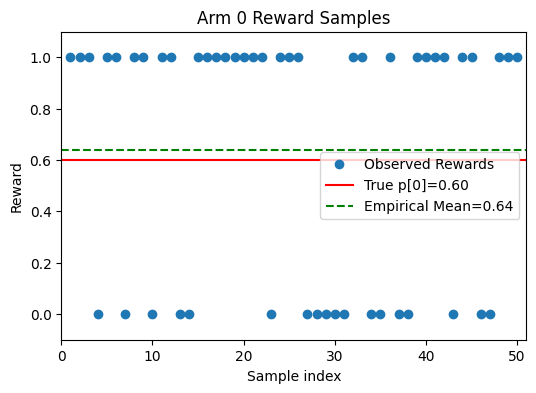

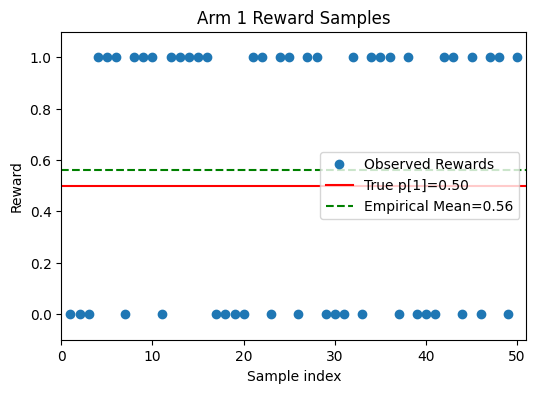

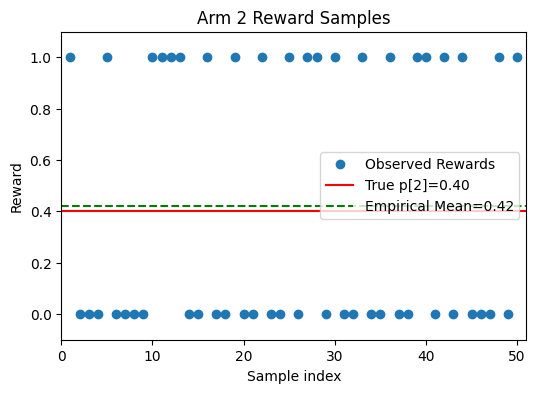

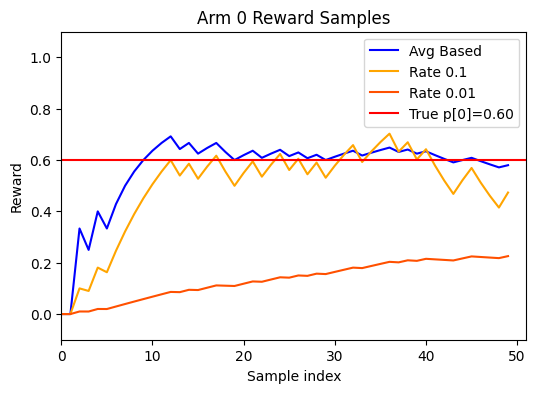

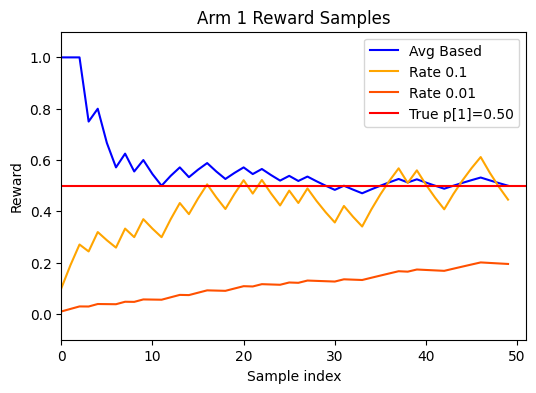

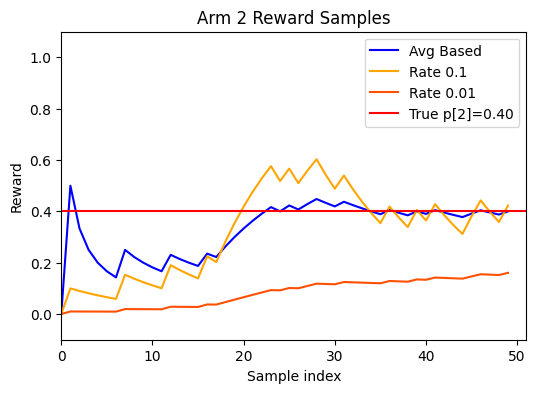

100%|██████████| 100/100 [00:00<00:00, 545.17it/s]


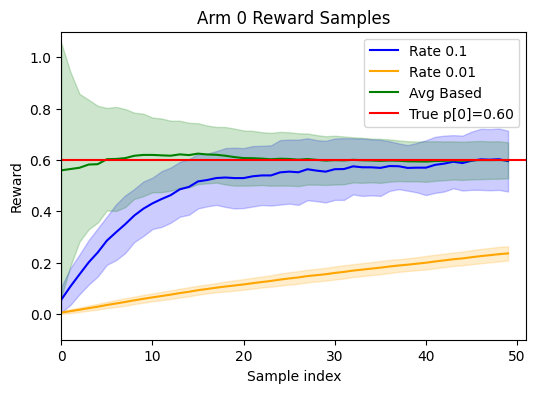

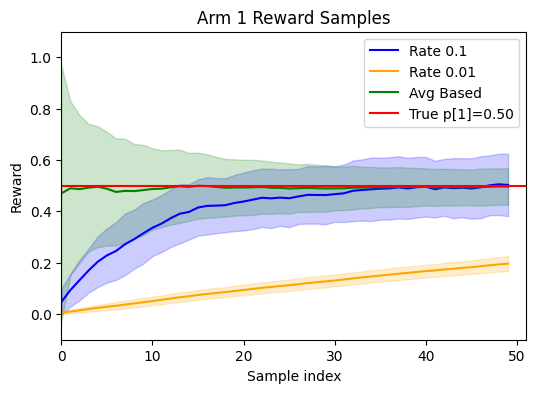

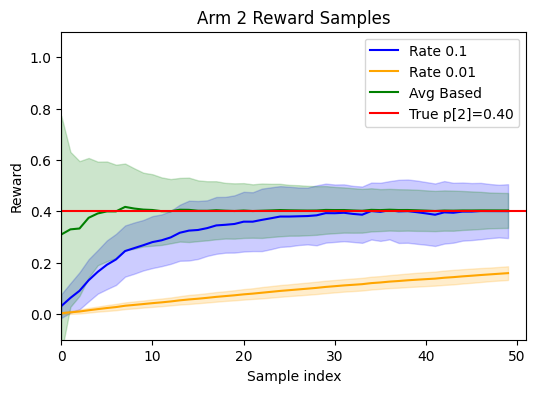

In [36]:
import random
from typing import List
import numpy as np
import matplotlib.pyplot as plt
import random
from numpy.random.mtrand import beta
import math
import tqdm


delta = 0.1

# p[i] = Bernoulli success probability for arm i
p: List[float] = [0.5 + delta, 0.5, 0.5 - delta]


class Bandit:
    def __init__(self, p: List[float]):
        self.p = p
        self.k = len(p)
        self.n = [0] * self.k
        self.learning_rate = 0.1

    def sample(self, action_index: int) -> int:
        rand_value: float = random.random()
        reward: int = 1 if rand_value < p[action_index] else 0
        # reward = np.random.binomial(1, p[action_index], 1)[0]
        self.n[action_index] += 1
        return reward


class Estimator:
    def __init__(self, bandit, learning_rates=[0.1, 0.01]):
        self.bandit = bandit
        self.q_estimate_avg_based = np.zeros(bandit.k)
        self.history_avg_based = [[] for _ in range(bandit.k)]
        self.learning_rates = learning_rates
        self.q_estimates_rate_based = [
            np.zeros(bandit.k) for _ in range(len(learning_rates))
        ]
        self.history_rate_based = [
            [[] for _ in range(bandit.k)] for _ in range(len(learning_rates))
        ]

    def update(self, action_index, reward):
        vals = []
        for i, alpha in enumerate(self.learning_rates):
            self.q_estimates_rate_based[i][action_index] += alpha * (
                reward - self.q_estimates_rate_based[i][action_index]
            )
            self.history_rate_based[i][action_index].append(
                self.q_estimates_rate_based[i][action_index]
            )
            vals.append(self.q_estimates_rate_based[i][action_index])
        return vals

    def updateAvg(self, action_index, reward):
        self.q_estimate_avg_based[action_index] += (
            reward - self.q_estimate_avg_based[action_index]
        ) / self.bandit.n[action_index]
        self.history_avg_based[action_index].append(
            self.q_estimate_avg_based[action_index]
        )
        return self.q_estimate_avg_based[action_index]


class Player:
    # epsilon greedy
    def __init__(self, bandit, epsilon=0.1, estimator=None):
        self.bandit = bandit
        self.epsilon = epsilon
        # self.q_estimate = np.zeros(bandit.k)
        self.n = np.zeros(bandit.k)
        self.estimator = estimator

    def play(self, count=100):
        if random.random() < self.epsilon:
            action_index = random.randint(0, self.bandit.k - 1)
        else:
            action_index = np.argmax(self.q_estimate)
        for _ in range(count):
            reward = self.bandit.sample(action_index)
            self.estimator.update(action_index, reward)
            self.estimator.updateAvg(action_index, reward)
        return self.estimator
        # self.n[action_index] += 1
        # self.q_estimate[action_index] += (
        #     reward - self.q_estimate[action_index]
        # ) / self.n[action_index]
        # return reward


# Q1
def run_q1():
    mybandit = Bandit(p)
    results_q2 = []
    sample_size_q1 = 50
    # Run 50 samples for each arm
    for action_index in range(mybandit.k):
        arm_samples = []
        for _ in range(sample_size_q1):
            reward = mybandit.sample(action_index)
            arm_samples.append(reward)
        results_q2.append(arm_samples)

    for action_index in range(mybandit.k):
        samples = results_q2[action_index]  # The 50 samples for this arm
        emp_mean = sum(samples) / len(samples)

        plt.figure(figsize=(6, 4))
        # Plot discrete rewards (0 or 1) at their sample index
        plt.plot(range(1, len(samples) + 1), samples, "o", label="Observed Rewards")

        # True parameter (drawn as a solid red line)
        plt.axhline(
            y=p[action_index],
            color="r",
            linestyle="-",
            label=f"True p[{action_index}]={p[action_index]:.2f}",
        )

        # Empirical mean (drawn as a dashed green line)
        plt.axhline(
            y=emp_mean,
            color="g",
            linestyle="--",
            label=f"Empirical Mean={emp_mean:.2f}",
        )

        plt.ylim([-0.1, 1.1])
        plt.xlim([0, sample_size_q1 + 1])  # 1..50
        plt.xlabel("Sample index")
        plt.ylabel("Reward")
        plt.title(f"Arm {action_index} Reward Samples")
        plt.legend()
        plt.show()


# Q2
def run_q2(plot=True, sample_size=50):
    mybandit = Bandit(p)
    estimator = Estimator(mybandit)
    results_q2 = []

    samples = np.zeros((3, sample_size))

    # Run 50 samples for each arm
    for action_index in range(mybandit.k):
        arm_samples = []
        estimate_samples = []
        for _ in range(sample_size):
            reward = mybandit.sample(action_index)
            arm_samples.append(reward)
            estimator.updateAvg(action_index, reward)
            estimator.update(action_index, reward)
        results_q2.append(arm_samples)
    if plot:
        for action_index in range(mybandit.k):
            samples = results_q2[action_index]  # The 50 samples for this arm

            plt.figure(figsize=(6, 4))
            # Plot discrete rewards (0 or 1) at their sample index
            # plt.plot(range(0, len(samples)), samples, "o", label="Observed Rewards")
            plt.plot(
                range(0, len(samples)),
                estimator.history_avg_based[action_index],
                "-",
                label="Avg Based",
                color="blue",
            )
            plt.plot(
                range(0, len(samples)),
                estimator.history_rate_based[0][action_index],
                "-",
                label="Rate 0.1 ",
                color="orange",
            )
            plt.plot(
                range(0, len(samples)),
                estimator.history_rate_based[1][action_index],
                "-",
                label="Rate 0.01",
                color="#ff5000",
            )

            # True parameter (drawn as a solid red line)
            plt.axhline(
                y=p[action_index],
                color="r",
                linestyle="-",
                label=f"True p[{action_index}]={p[action_index]:.2f}",
            )

            plt.ylim([-0.1, 1.1])
            plt.xlim([0, sample_size + 1])  # 1..50
            plt.xlabel("Sample index")
            plt.ylabel("Reward")
            plt.title(f"Arm {action_index} Reward Samples")
            plt.legend()
            plt.show()
    return estimator, results_q2


def run_q3():
    sample_size = 50
    estimators = []
    results_q3 = []
    q_estimates_rate_01_history = []
    q_estimates_rate_001_history = []
    q_estimates_avg_based_history = []

    for i in tqdm.tqdm(range(100)):
        estimator, result = run_q2(plot=False, sample_size=sample_size)
        estimators.append(estimator)
        results_q3.append(result)
        q_estimates_rate_01_history.append(estimator.history_rate_based[0])
        q_estimates_rate_001_history.append(estimator.history_rate_based[1])
        q_estimates_avg_based_history.append(estimator.history_avg_based)

    q_estimates_rate_001_history_avg = np.mean(q_estimates_rate_001_history, axis=0)
    q_estimates_rate_01_history_avg = np.mean(q_estimates_rate_01_history, axis=0)
    q_estimates_rate_001_history_std = np.std(q_estimates_rate_001_history, axis=0)
    q_estimates_rate_01_history_std = np.std(q_estimates_rate_01_history, axis=0)

    q_estimates_avg_based_history_avg = np.mean(q_estimates_avg_based_history, axis=0)
    q_estimates_avg_based_history_std = np.std(q_estimates_avg_based_history, axis=0)

    # plot
    for action_index in range(3):
        plt.figure(figsize=(6, 4))
        plt.plot(
            range(0, sample_size),
            q_estimates_rate_01_history_avg[action_index],
            "-",
            label="Rate 0.1",
            color="blue",
        )
        plt.fill_between(
            range(0, sample_size),
            q_estimates_rate_01_history_avg[action_index]
            - q_estimates_rate_01_history_std[action_index],
            q_estimates_rate_01_history_avg[action_index]
            + q_estimates_rate_01_history_std[action_index],
            color="blue",
            alpha=0.2,
        )
        plt.plot(
            range(0, sample_size),
            q_estimates_rate_001_history_avg[action_index],
            "-",
            label="Rate 0.01",
            color="orange",
        )
        plt.fill_between(
            range(0, sample_size),
            q_estimates_rate_001_history_avg[action_index]
            - q_estimates_rate_001_history_std[action_index],
            q_estimates_rate_001_history_avg[action_index]
            + q_estimates_rate_001_history_std[action_index],
            color="orange",
            alpha=0.2,
        )

        plt.plot(
            range(0, sample_size),
            q_estimates_avg_based_history_avg[action_index],
            "-",
            label="Avg Based",
            color="green",
        )
        plt.fill_between(
            range(0, sample_size),
            q_estimates_avg_based_history_avg[action_index]
            - q_estimates_avg_based_history_std[action_index],
            q_estimates_avg_based_history_avg[action_index]
            + q_estimates_avg_based_history_std[action_index],
            color="green",
            alpha=0.2,
        )

        # True parameter (drawn as a solid red line)
        plt.axhline(
            y=p[action_index],
            color="r",
            linestyle="-",
            label=f"True p[{action_index}]={p[action_index]:.2f}",
        )
        plt.legend()
        plt.title(f"Arm {action_index} Reward Samples")
        plt.xlabel("Sample index")
        plt.ylabel("Reward")

        plt.ylim([-0.1, 1.1])
        plt.xlim([0, sample_size + 1])


def run_q4():
    bandit = Bandit(p)
    player = Player(bandit, epsilon=0.1, estimator=Estimator(bandit))
    # 1000 timesteps means 1000 pull arm
    player.play(1000)


run_q1()
run_q2()
run_q3()
run_q4()

100%|██████████| 100/100 [00:00<00:00, 4510.59it/s]
